In [1]:
import soundfile as sf
import numpy as np
import torch
import torchaudio
import matplotlib.pyplot as plt

In [46]:
import torch
import torch.fft as fft

def hilbert_transform(signal):
    # Compute the FFT of the signal
    fft_result = fft.fft(signal)

    # Create a frequency vector
    n = signal.shape[-1]
    freq_vector = torch.fft.fftfreq(n, d=1.0)

    # Generate the Hilbert kernel
    hilbert_kernel = torch.zeros_like(freq_vector)
    hilbert_kernel[1:n//2] = -1j  # Positive frequencies
    hilbert_kernel[n//2+1:] = 1j   # Negative frequencies

    # Apply the Hilbert kernel in the frequency domain
    hilbert_result_freq = fft_result * hilbert_kernel

    # Compute the inverse FFT to obtain the Hilbert Transform
    hilbert_result = fft.ifft(hilbert_result_freq)

    # Return the complex-valued analytic signal
    return hilbert_result

def est_finst(X):
    n_fft = (X.shape[0]-1)*2
    k = torch.arange(0, X.shape[0], 1).view(-1, 1)
    W = torch.exp(-1j*2*torch.pi*k/n_fft)
    Z = X[:, :-1] * torch.conj(X[:, 1:]) * W
    f_inst = Z.I()
    return f_inst

def est_groupdelay(x, fs):
    n = torch.arange(0, x.shape[-1], 1) / fs
    X = torch.stft(x, 512, 128, 512, return_complex=True)
    Y = torch.stft(x*n, 512, 128, 512, return_complex=True)
    gd = (X.real * Y.real + X.imag * Y.imag) / X.abs()    
    return gd

In [35]:
fname = r'/media/avi/54561652561635681/datasets/ARCTIC/cmu_us_aew_arctic/wav/arctic_a0004.wav'
x, fs = sf.read(fname)
x = torch.from_numpy(x)
X = torch.stft(x, 512, 32, 512, return_complex=True)

ValueError: not enough values to unpack (expected 2, got 1)

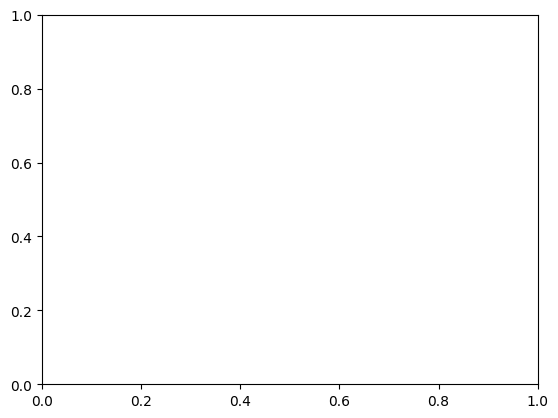

In [36]:
gd = hilbert_transform(x)
plt.pcolor(gd.abs())
plt.show()

In [48]:
t = torch.arange(0, 1+1/100, 1/100)
print(t.shape)
f = 10
x = torch.sin(2*np.pi*f*t)
X = hilbert_transform(x)
import scipy.signal as ss
Xs = torch.from_numpy(ss.hilbert(x.numpy()))
X-Xs

torch.Size([101])


RuntimeError: value cannot be converted to type float without overflow

In [49]:
import numpy as np
from scipy.signal import hilbert

# Assuming input_signal is a numpy array
input_signal = np.array([1.0, 2.0, 3.0, 4.0, 5.0], dtype=np.float32)
hilbert_result = hilbert_transform(torch.from_numpy(input_signal))
hilbert_result2 = hilbert(input_signal)

print("Input Signal:", input_signal)
print("Hilbert Transform:", hilbert_result)
print("Hilbert Transform:", hilbert_result2)

RuntimeError: value cannot be converted to type float without overflow

In [ ]:
Xa = hilbert_transform(X)
f_inst = est_finst(Xa) * (fs / (2 * np.pi))
fig, ax = plt.subplots(1)
ax.pcolor(f_inst)
plt.show()

In [1]:
import glob
import matplotlib.pyplot as plt
import pickle
import os
import torch


data_path = r"/media/avi/54561652561635681/datasets/ARCTIC"
fnames = glob.glob(data_path + '/**/wav/*.wav')
fnames = [f for f in fnames if os.path.isfile(f)]
speakers = list(set([f.split('/')[-3].split('_')[-2] for f in fnames]))

with open("../hubert0.5.pkl", 'rb') as f:   # google colab
    hubert_units05 = pickle.load(f)

res05 = {}
for s in speakers:
    res05[s] = torch.tensor([u.std()for u in hubert_units05[s]]).mean()

del hubert_units05

In [3]:
with open("../hubert1.pkl", 'rb') as f:   # google colab
    hubert_units1 = pickle.load(f)

res1 = {}
for s in speakers:
    res1[s] = torch.tensor([u[0].std()for u in hubert_units1[s]]).mean()

del hubert_units1

In [4]:
with open("../hubert4.pkl", 'rb') as f:   # google colab
    hubert_units4 = pickle.load(f)
    
res4 = {}
for s in speakers:
    res4[s] = torch.tensor([u[0].std()for u in hubert_units4[s]]).mean()

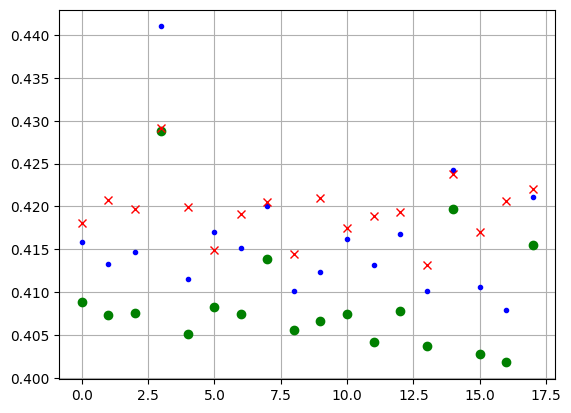

In [5]:
plt.plot(res05.values(), 'b.')
plt.plot(res1.values(), 'go')
plt.plot(res4.values(), 'rx')
plt.grid(True)
plt.show()

In [11]:
torch.tensor(list(res05.values())).std(), torch.tensor(list(res1.values())).std(), torch.tensor(list(res4.values())).std()

(tensor(0.0075), tensor(0.0067), tensor(0.0036))